Fundamentos de analítica 2 (clase 4) - Diego Fernando Agudelo - Universidad ICESI - diegoagudelo30@gmail.com

# Fundamentos-analitica-II
Repositorio de trabajos para la asignatura de la maestría en Ciencia de Datos

FACULTAD DE INGENIERÍA, DISEÑO Y CIENCIAS 
APLICADAS 
MAESTRÍA EN CIENCIA DE DATOS 
TIC 60153 – Fundamentos de analítica II 

Grupo: 

DANIEL DELGADO - FABIAN SALAZAR FIGUEROA

En días recientes trabajamos con una compañía de comestibles que estaba interesada en predecir el comportamiento de las ventas (en unidades) de sus dos productos estrella. Fuimos contratados para generar un modelo que permita pronosticar las ventas del siguiente mes de cada uno de esos dos productos. La base de datos disponible en el archivo Examen.csv tiene la información de cada uno de los productos desde enero de 2008.

Su misión es encontrar el mejor modelo para pronosticar cada una de las series. Usted debe entregar un informe escrito de no más de cuatro páginas que presente los resultados al cliente y cuente el proceso para llegar a los pronósticos. Vea las instrucciones para asegurar que entrega los archivos requeridos

### Instrucciones
El examen se compone de dos partes:
- La primera corresponde a una parte de selección múltiple con 19 preguntas que se responderán en el salón de clase en 45 minutos. Esa primera parte tiene una calificación de 1 a 5.
-La segunda parte corresponde a la parte práctica del examen y tiene también una calificación de 1 a 5.

- La nota de este examen parcial corresponderá al promedio ponderado de las dos notas, donde la parte práctica tiene un peso de 40 % y la parte de selección múltiple de 60 %.
- Usted tiene hasta el 30 de agosto a las 12:00 pm para enviar los archivos por correo, estos archivos deben tener su nombre.
- Sólo se calificaran exámenes en formato pdf. Cualquier otro formato no será tenido en cuenta.
- El examen debe estar acompañado de un notebook (ipynb)  que incluya todo los códigos de python que se emplean para obtener sus resultados.
- El nombre del archivo debe tener su nombre. No se recibirán archivos en otro formato.
- Esta parte del examen es para realizar en casa y debe reflejar el trabajo individual.

## **1. Carga de paquetes**

In [1]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
#!pip install fastai wwf bayesian-optimization -q --upgrade
from bayes_opt import BayesianOptimization
from datetime import datetime, timedelta

## **2. Carga de datos**

Nuestra primera tarea será leer el archivo csv. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [2]:
data = pd.read_csv(r"https://raw.githubusercontent.com/alfa7g7/Fundamentos-analitica-II/main/UNIDAD%20I/Clase%204/Examen.csv", sep=',')
data.head()

,Unnamed: 0,producto1,producto2
0,1,4000.000000,3000.000000
1,2,3997.400893,3010.686220
2,3,3978.605317,3022.018584
3,4,3986.454125,3033.920990
4,5,3979.695678,3038.402098


(127, 3)


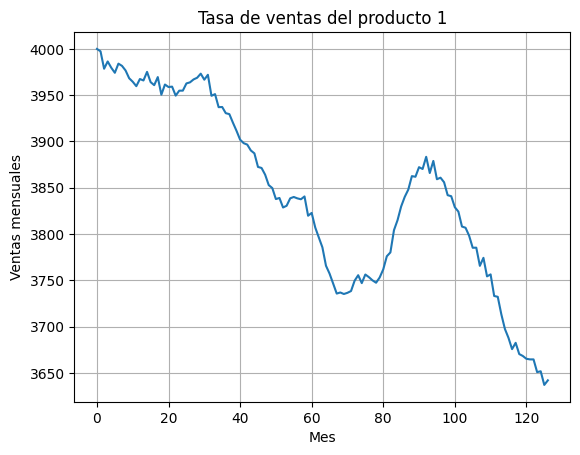

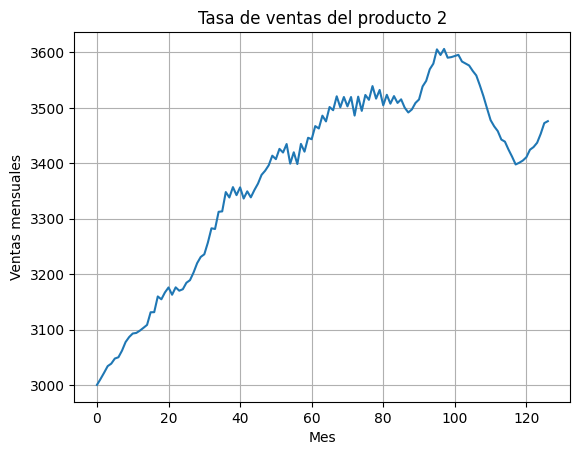

In [3]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos de producto1 y produto2
plt.title("Tasa de ventas del producto 1")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto1"]])
plt.grid()
plt.show()

plt.title("Tasa de ventas del producto 2")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto2"]])
plt.grid()
plt.show()

## **3. EDA**

### 3.1 Procedemos a hacer un análisis corto de EDA para verificar tamaño del conjunto de datos para cada serie de tiempo, nulos (si hay) y algunas cuantificaciones estadísticas

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  127 non-null    int64  
 1   producto1   127 non-null    float64
 2   producto2   127 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.1 KB


In [5]:
#Determinamos si existen nulos en las series de tiempo
data.isnull().sum()

Unnamed: 0    0
producto1     0
producto2     0
dtype: int64

In [6]:
# Estadsiticas del conjunto de datos de tendencia central
data.describe()

,Unnamed: 0,producto1,producto2
count,127.000000,127.000000,127.000000
mean,64.000000,3843.571660,3381.037664
std,36.805797,100.234821,167.504363
min,1.000000,3637.047639,3000.000000
25%,32.500000,3756.853812,3269.194001
50%,64.000000,3840.644019,3426.048401
75%,95.500000,3950.071775,3508.941718
max,127.000000,4000.000000,3606.440615


### 3.2 Ahora debemos convertir en índice la variable sin nombre: 'Unnamed: 0'  que representa los meses desde enero del 2008 como lo indica el enunciado del problema y expresarla en forma de fecha para mejorar el entendimiento y procesamiento

In [7]:
# Renombrar la columna 'Unnamed: 0' a 'Mes'
data.rename(columns={'Unnamed: 0': 'Mes'}, inplace=True)

# Función para convertir un número de mes a una fecha
def convertir_mes_a_fecha(mes, start_date):
    # Calcular el año y el mes correspondientes
    year = start_date.year + (mes - 1) // 12
    month = (start_date.month + (mes - 1) % 12 - 1) % 12 + 1
    return datetime(year, month, 1)

# Fecha de inicio (enero de 2008)
start_date = datetime(2008, 1, 1)

# Aplicar la función a la columna 'Mes'
data['Mes'] = data['Mes'].apply(lambda x: convertir_mes_a_fecha(x, start_date))

print(data)


           Mes    producto1    producto2
0   2008-01-01  4000.000000  3000.000000
1   2008-02-01  3997.400893  3010.686220
2   2008-03-01  3978.605317  3022.018584
3   2008-04-01  3986.454125  3033.920990
4   2008-05-01  3979.695678  3038.402098
..         ...          ...          ...
122 2018-03-01  3664.610771  3429.293034
123 2018-04-01  3650.881839  3437.099467
124 2018-05-01  3651.788470  3453.155282
125 2018-06-01  3637.047639  3472.528345
126 2018-07-01  3641.990873  3476.058092

[127 rows x 3 columns]


In [8]:
# Establecer la columna 'Mes' como índice
data.set_index('Mes', inplace=True)

print(data)

              producto1    producto2
Mes                                 
2008-01-01  4000.000000  3000.000000
2008-02-01  3997.400893  3010.686220
2008-03-01  3978.605317  3022.018584
2008-04-01  3986.454125  3033.920990
2008-05-01  3979.695678  3038.402098
...                 ...          ...
2018-03-01  3664.610771  3429.293034
2018-04-01  3650.881839  3437.099467
2018-05-01  3651.788470  3453.155282
2018-06-01  3637.047639  3472.528345
2018-07-01  3641.990873  3476.058092

[127 rows x 2 columns]


In [9]:
#miramos nuevamente como queda el dataframe con estas transformaciones
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2008-01-01 to 2018-07-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   producto1  127 non-null    float64
 1   producto2  127 non-null    float64
dtypes: float64(2)
memory usage: 3.0 KB


In [10]:
data.shape

(127, 2)

In [11]:
#Determinamos si existen nulos en las series de tiempo
data.isnull().sum()

producto1    0
producto2    0
dtype: int64

In [12]:
# Estadsiticas del conjunto de datos de tendencia central
data.describe()

,producto1,producto2
count,127.000000,127.000000
mean,3843.571660,3381.037664
std,100.234821,167.504363
min,3637.047639,3000.000000
25%,3756.853812,3269.194001
50%,3840.644019,3426.048401
75%,3950.071775,3508.941718
max,4000.000000,3606.440615


### 3.3 Ya con esta pequeñas transformaciones tenemos nuestro conjunto de datos listo para trabajarlo y proceder a hacer todo lo necesario para llevar a cabo los pronósticos de cada serie de tiempo de los dos prodcutos estrellas de la empresa

(127, 2)


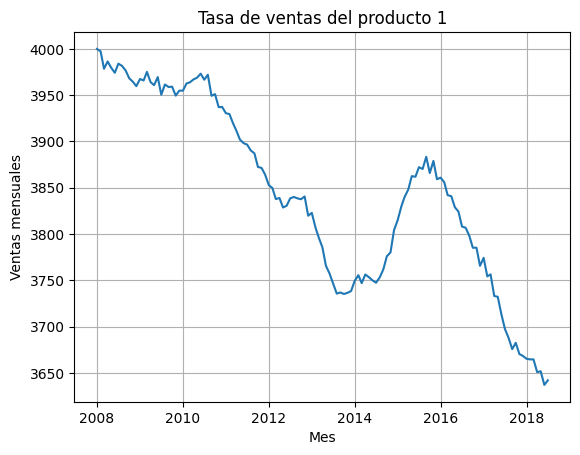

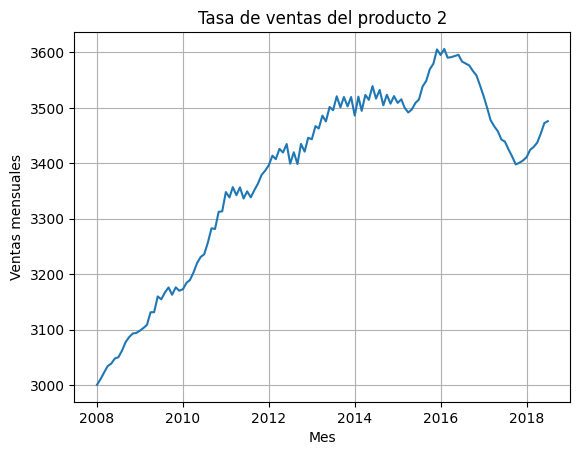

In [13]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos de producto1 y produto2
plt.title("Tasa de ventas del producto 1")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto1"]])
plt.grid()
plt.show()

plt.title("Tasa de ventas del producto 2")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto2"]])
plt.grid()
plt.show()

### 3.4 Encontrando los componentes de las series de tiempo para los productos 1 y 2

En algunas ocasiones puede ser útil empezar nuestro análisis descomponiendo la serie de tiempo en sus componentes: **tendencia**, **estacionalidad** y **componente puramente aleatorio**. Una forma de hacer esto es empleando la función seasonal_decompose.

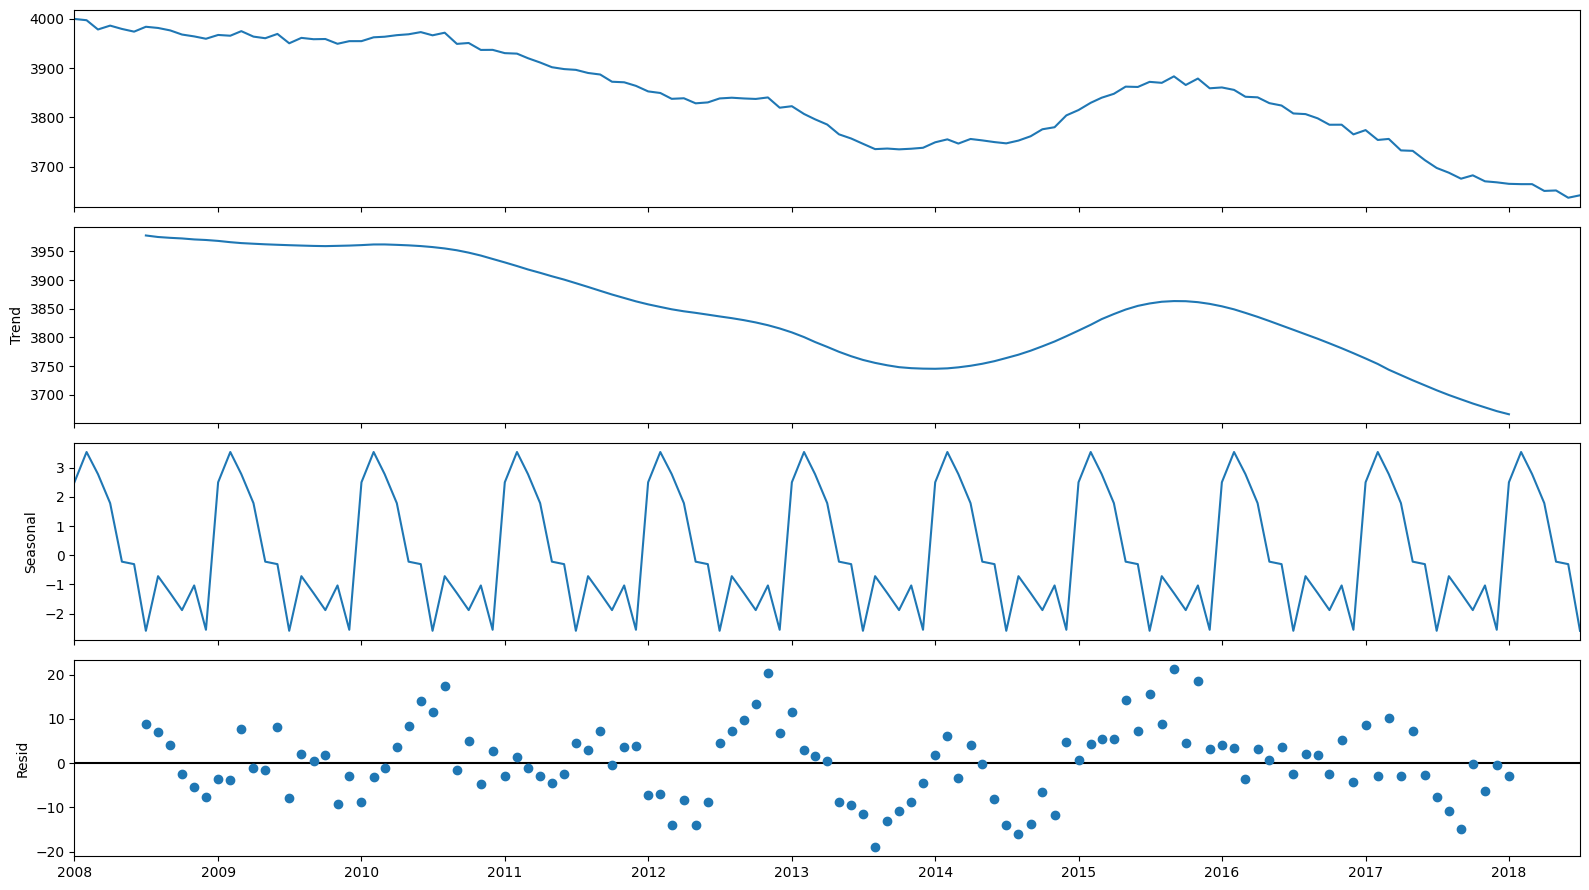

In [14]:
#Componentes serie de tiempo prodcuto1
td_componentes_producto1 = seasonal_decompose(data[["producto1"]],model="additive")
fig = td_componentes_producto1.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

**Podemos observar el componente estacional marcado en la serie de producto1, una tendencia no lineal de los datos y la parte aleatoria.**

Observamos cada componente de la serie de tiempo del producto1

In [15]:
td_componentes_producto1.seasonal

Mes
2008-01-01    2.495315
2008-02-01    3.531537
2008-03-01    2.775396
2008-04-01    1.781834
2008-05-01   -0.220084
                ...   
2018-03-01    2.775396
2018-04-01    1.781834
2018-05-01   -0.220084
2018-06-01   -0.304548
2018-07-01   -2.585303
Name: seasonal, Length: 127, dtype: float64

In [16]:
td_componentes_producto1.trend

Mes
2008-01-01   NaN
2008-02-01   NaN
2008-03-01   NaN
2008-04-01   NaN
2008-05-01   NaN
              ..
2018-03-01   NaN
2018-04-01   NaN
2018-05-01   NaN
2018-06-01   NaN
2018-07-01   NaN
Name: trend, Length: 127, dtype: float64

In [17]:
td_componentes_producto1.resid

Mes
2008-01-01   NaN
2008-02-01   NaN
2008-03-01   NaN
2008-04-01   NaN
2008-05-01   NaN
              ..
2018-03-01   NaN
2018-04-01   NaN
2018-05-01   NaN
2018-06-01   NaN
2018-07-01   NaN
Name: resid, Length: 127, dtype: float64

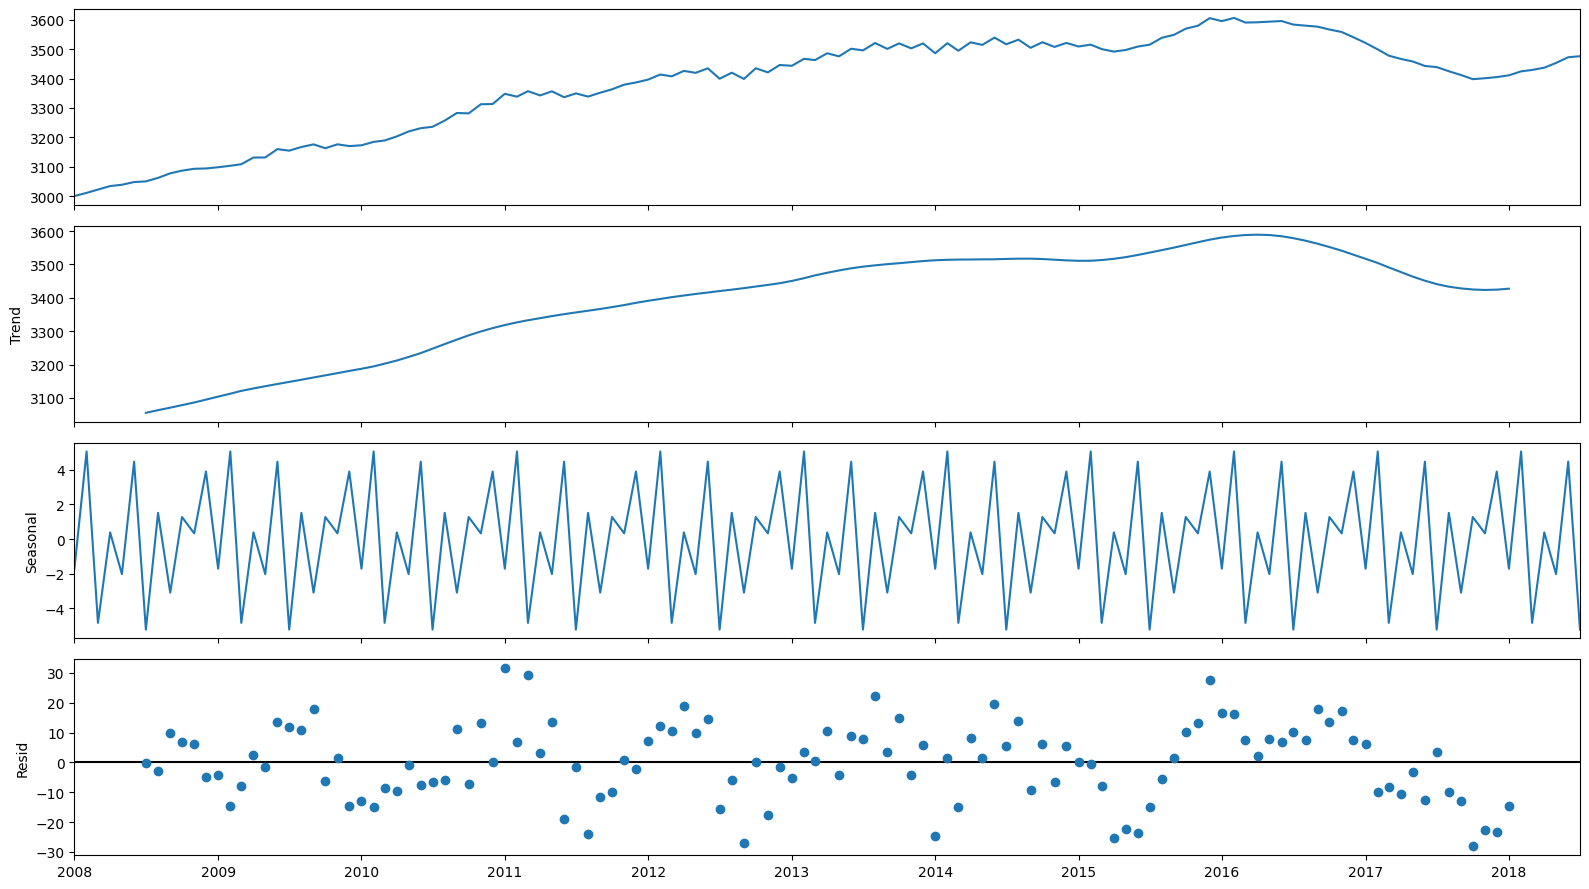

In [18]:
#Componentes serie de tiempo prodcuto2
td_componentes_producto2 = seasonal_decompose(data[["producto2"]],model="additive")
fig = td_componentes_producto2.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

**Podemos observar el componente estacional marcado en la serie producto2, una tendencia no lineal de los datos y la parte aleatoria.**

Observamos cada componente de la serie de tiempo del producto2

In [19]:
td_componentes_producto2.seasonal

Mes
2008-01-01   -1.709341
2008-02-01    5.041275
2008-03-01   -4.827994
2008-04-01    0.382215
2008-05-01   -2.021890
                ...   
2018-03-01   -4.827994
2018-04-01    0.382215
2018-05-01   -2.021890
2018-06-01    4.453935
2018-07-01   -5.214986
Name: seasonal, Length: 127, dtype: float64

In [20]:
td_componentes_producto2.trend

Mes
2008-01-01   NaN
2008-02-01   NaN
2008-03-01   NaN
2008-04-01   NaN
2008-05-01   NaN
              ..
2018-03-01   NaN
2018-04-01   NaN
2018-05-01   NaN
2018-06-01   NaN
2018-07-01   NaN
Name: trend, Length: 127, dtype: float64

In [21]:
td_componentes_producto2.resid

Mes
2008-01-01   NaN
2008-02-01   NaN
2008-03-01   NaN
2008-04-01   NaN
2008-05-01   NaN
              ..
2018-03-01   NaN
2018-04-01   NaN
2018-05-01   NaN
2018-06-01   NaN
2018-07-01   NaN
Name: resid, Length: 127, dtype: float64

Procedemos a realizar una gráfica para comparar ambas series donde vemos el comportamiento de cada producto respecto al otro

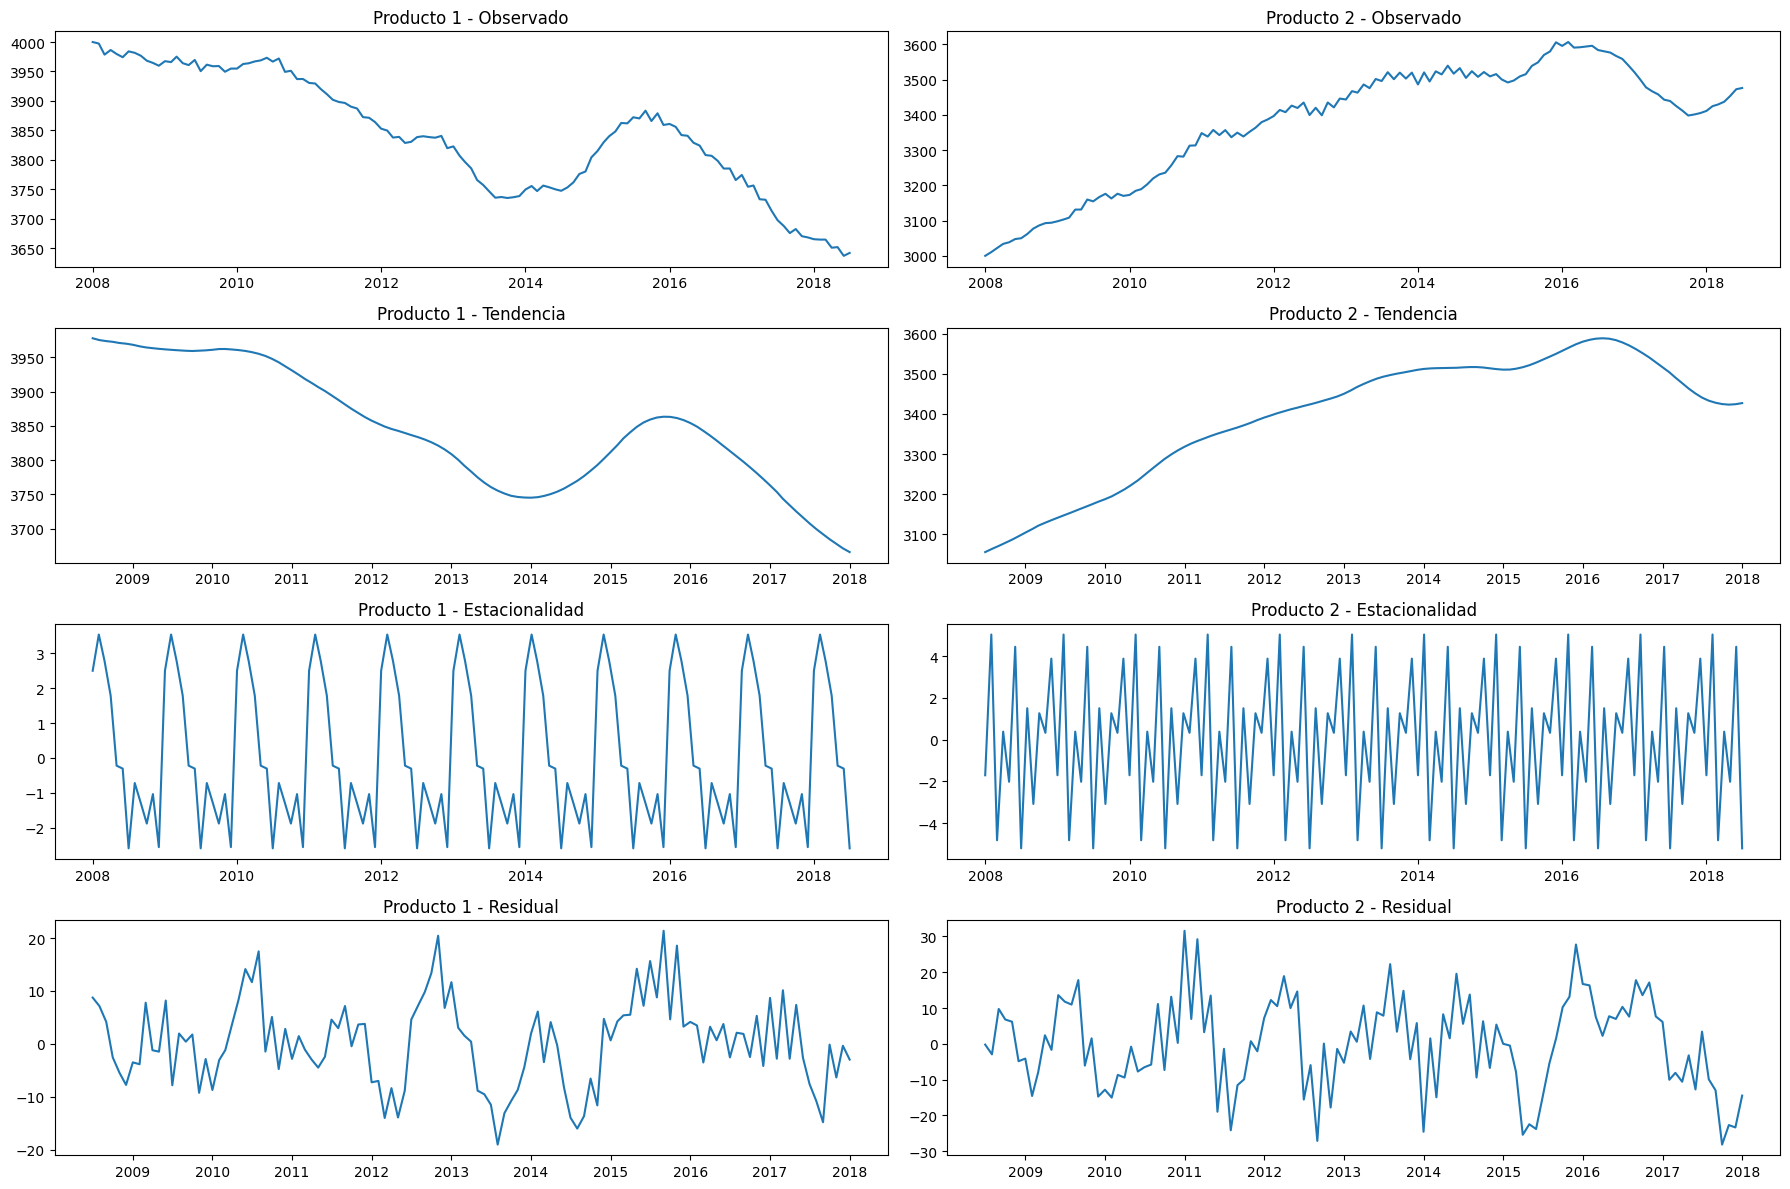

In [22]:
# Crear subplots
fig, axes = plt.subplots(4, 2, figsize=(18, 12))

# Graficar los componentes de producto1
axes[0, 0].plot(td_componentes_producto1.observed)
axes[0, 0].set_title('Producto 1 - Observado')
axes[1, 0].plot(td_componentes_producto1.trend)
axes[1, 0].set_title('Producto 1 - Tendencia')
axes[2, 0].plot(td_componentes_producto1.seasonal)
axes[2, 0].set_title('Producto 1 - Estacionalidad')
axes[3, 0].plot(td_componentes_producto1.resid)
axes[3, 0].set_title('Producto 1 - Residual')

# Graficar los componentes de producto2
axes[0, 1].plot(td_componentes_producto2.observed)
axes[0, 1].set_title('Producto 2 - Observado')
axes[1, 1].plot(td_componentes_producto2.trend)
axes[1, 1].set_title('Producto 2 - Tendencia')
axes[2, 1].plot(td_componentes_producto2.seasonal)
axes[2, 1].set_title('Producto 2 - Estacionalidad')
axes[3, 1].plot(td_componentes_producto2.resid)
axes[3, 1].set_title('Producto 2 - Residual')

# Ajustar el layout
plt.tight_layout()
plt.show()

Aquí notamos que la tendencia de cada producto ha sido inversa es decir: el producto1 tiene una tendencia hacia la baja y el producto2 una tendencia a la alza; pero debemos observar que también a pesar de esto al final ambos prodcutos se encuentran en una ventas similares en cantidad aunque aún vende más el producto1. 

## **4. PROTOCOLOS DE EVALUACION**

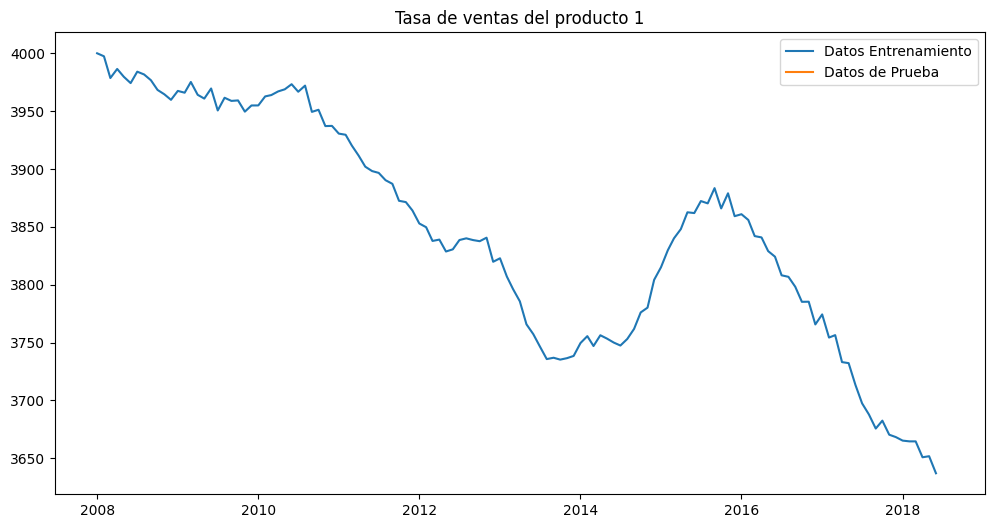

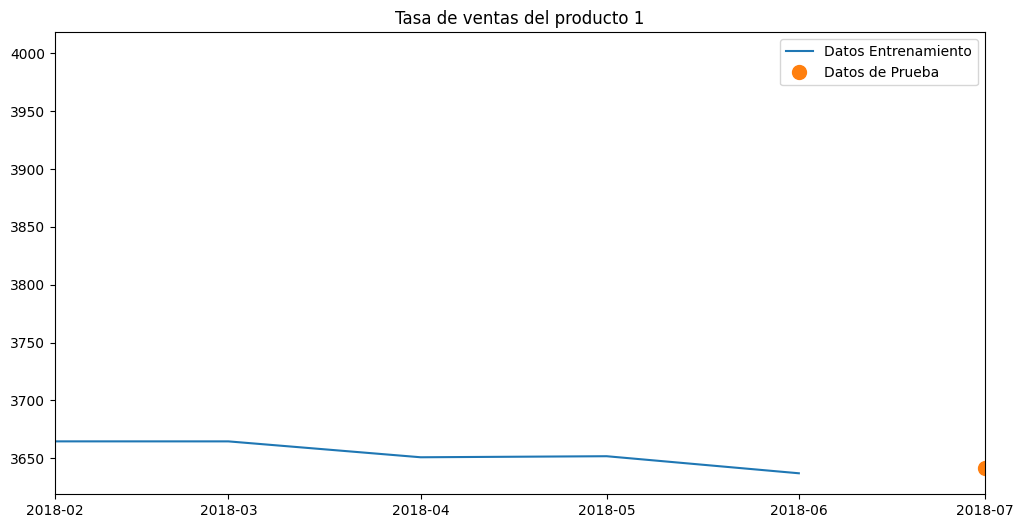

In [23]:
train_len = len(data) - 1
train_producto1 = data[["producto1"]][:train_len]
test_producto1 = data[["producto1"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.title("Tasa de ventas del producto 1")
plt.plot(train_producto1,label="Datos Entrenamiento")
plt.plot(test_producto1,label="Datos de Prueba")
plt.legend()
plt.show()

# Acercamos un poco la gráfica para identificar el punto de prueba
fig = plt.figure(figsize=(12, 6))
plt.title("Tasa de ventas del producto 1")
plt.plot(train_producto1, label="Datos Entrenamiento")
plt.plot(test_producto1, label="Datos de Prueba", marker='o', markersize=10, linestyle='None')
plt.legend()

# Ajustar los límites del eje x para enfocarse en los últimos puntos
plt.xlim(train_producto1.index[-5], test_producto1.index[-1])

plt.show()

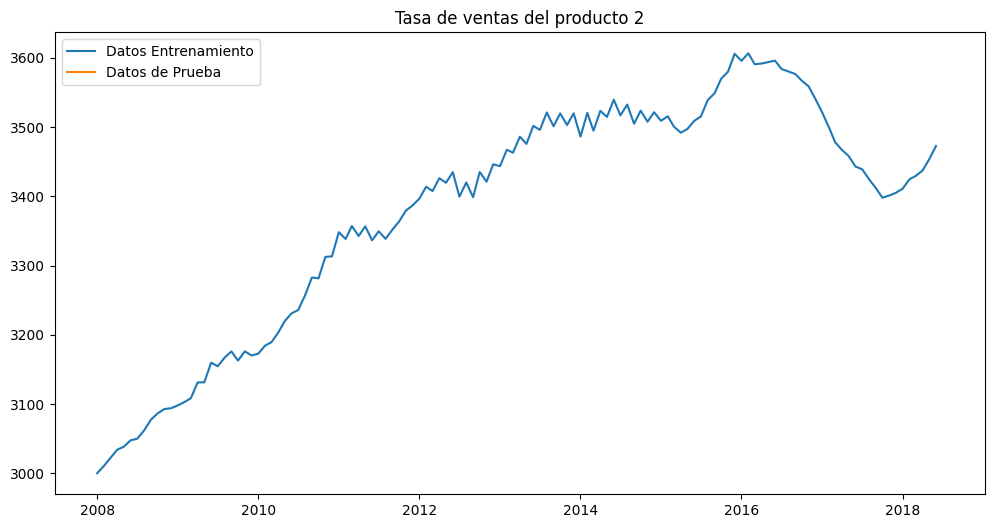

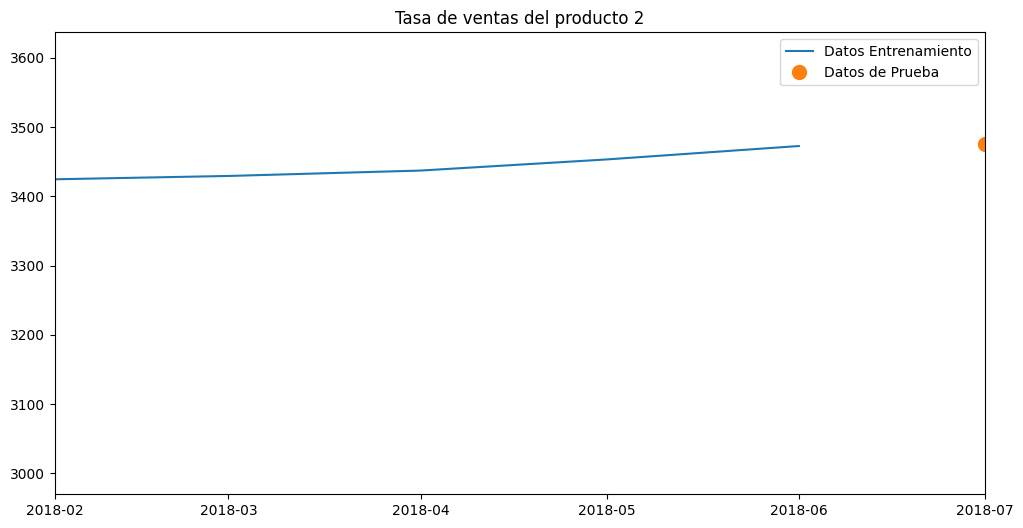

In [24]:
train_len = len(data) - 1 
train_producto2 = data[["producto2"]][:train_len]
test_producto2 = data[["producto2"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.title("Tasa de ventas del producto 2")
plt.plot(train_producto2,label="Datos Entrenamiento")
plt.plot(test_producto2,label="Datos de Prueba")
plt.legend()
plt.show()

# Acercamos un poco la gráfica para identificar el punto de prueba
fig = plt.figure(figsize=(12, 6))
plt.title("Tasa de ventas del producto 2")
plt.plot(train_producto2, label="Datos Entrenamiento")
plt.plot(test_producto2, label="Datos de Prueba", marker='o', markersize=10, linestyle='None')
plt.legend()

# Ajustar los límites del eje x para enfocarse en los últimos puntos
plt.xlim(train_producto2.index[-5], test_producto2.index[-1])

plt.show()

### **4.1 Ventana Recursiva**

En un enfoque de ventana recursiva, entrenas el modelo con un conjunto de datos y luego lo usas para predecir un punto en el futuro. Después de obtener la predicción, amplías la ventana para incluir este nuevo punto y repites el proceso.

![alt text](image.png)

Ejemplo:

In [25]:
def recursive_forecast(model, train_data, test_data):
    """
    Realiza un pronóstico recursivo con el modelo dado.
    
    Parameters:
    - model: el modelo de pronóstico (debe tener un método `fit` y `predict`)
    - train_data: datos de entrenamiento
    - test_data: datos de prueba
    
    Returns:
    - predictions: lista de predicciones
    """
    predictions = []
    history = train_data.copy()
    
    for t in range(len(test_data)):
        model.fit(history)
        yhat = model.predict(1)
        predictions.append(yhat)
        history = np.append(history, test_data[t])  # actualizamos la ventana
        
    return predictions


### **4.2 Rolling window**

En una rolling window, mueves la ventana a lo largo del tiempo para generar predicciones, entrenando el modelo solo en los datos más recientes.

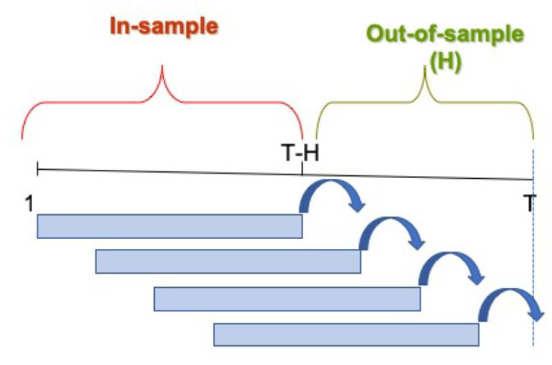

Ejemplo:

In [27]:
def rolling_forecast(model, train_data, test_data, window_size):
    """
    Realiza un pronóstico utilizando una ventana deslizante (rolling window).
    
    Parameters:
    - model: el modelo de pronóstico (debe tener un método `fit` y `predict`)
    - train_data: datos de entrenamiento
    - test_data: datos de prueba
    - window_size: tamaño de la ventana deslizante
    
    Returns:
    - predictions: lista de predicciones
    """
    predictions = []
    
    for t in range(len(test_data)):
        window = train_data[-window_size:]  # extraemos la ventana
        model.fit(window)
        yhat = model.predict(1)
        predictions.append(yhat)
        train_data = np.append(train_data, test_data[t])  # movemos la ventana
        
    return predictions


Dependiendo del modelo a usar se deben hacer algunos ajustes a las funciones para el correcto funcionamiento del protocolo de evaluación

## **5. MODELOS**

### 5.1 Promedio movil

El promedio móvil está dado por:

$$ F_{t + 1}=\frac{Y_{t} + Y_{t-1} + Y_{t-(k-1)} }{ k} $$

El método de los promedios móviles utiliza el promedio de los $k$
valores de datos más recientes en la serie de tiempo como el
pronóstico para el siguiente periodo.

El término móvil indica que, mientras se dispone de una nueva
observación para la serie de tiempo, reemplaza a la observación más
antigua de la ecuación anterior y se calcula un promedio nuevo.
Como resultado, el promedio cambiará, o se moverá, conforme surjan
nuevas observaciones.

$Y_{t}$ = Observación en el período t

$F_{t}$ = Pronóstico en el período t

#### 5.1.1 Promedio movil para producto1

In [28]:
## Considerando el dato actual
ma_2= train_producto1.rolling(2,min_periods=2).mean()
ma_3= train_producto1.rolling(3,min_periods=2).mean()
ma_4= train_producto1.rolling(4,min_periods=2).mean()
ma_5= train_producto1.rolling(5,min_periods=2).mean()

In [29]:
## Sin considerar el dato actual
ma_2= train_producto1.shift().rolling(2,min_periods=2).mean()
ma_3= train_producto1.shift().rolling(3,min_periods=2).mean()
ma_4= train_producto1.shift().rolling(4,min_periods=2).mean()
ma_5= train_producto1.shift().rolling(5,min_periods=2).mean()

In [30]:
def fore_ma(datos,w,h): #w es la ventana del promedio para hacer el pronostico (10,15,20,25,30) w=2 (10 con 15, 15 con 20, 20 con 25) w=3 (10 con 15 con 20, )..., h el num de pronosticos hacia adelante
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [31]:
ma_2_f= fore_ma(train_producto1,2,1)
ma_3_f= fore_ma(train_producto1,3,1)
ma_4_f= fore_ma(train_producto1,4,1)
ma_5_f= fore_ma(train_producto1,5,1)

In [32]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_producto1,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_producto1,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_producto1,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_producto1,ma_5_f ))

In [33]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5)

2.427181854649916 4.58177678748325 9.091307204057557 11.799965567419804


In [34]:
# Crear una lista con los valores de RMSE
rmse_values = [rmse_ma_2, rmse_ma_3, rmse_ma_4, rmse_ma_5]

# Encontrar el valor mínimo, que sería la mejor opción
min_rmse = min(rmse_values)

# Imprimir el valor mínimo y su correspondiente modelo
if min_rmse == rmse_ma_2:
    print(f"El mejor modelo es MA(2) con un RMSE de {min_rmse} para producto1")
elif min_rmse == rmse_ma_3:
    print(f"El mejor modelo es MA(3) con un RMSE de {min_rmse} para producto1")
elif min_rmse == rmse_ma_4:
    print(f"El mejor modelo es MA(4) con un RMSE de {min_rmse} para producto1")
else:
    print(f"El mejor modelo es MA(5) con un RMSE de {min_rmse} para producto1")

El mejor modelo es MA(2) con un RMSE de 2.427181854649916 para producto1


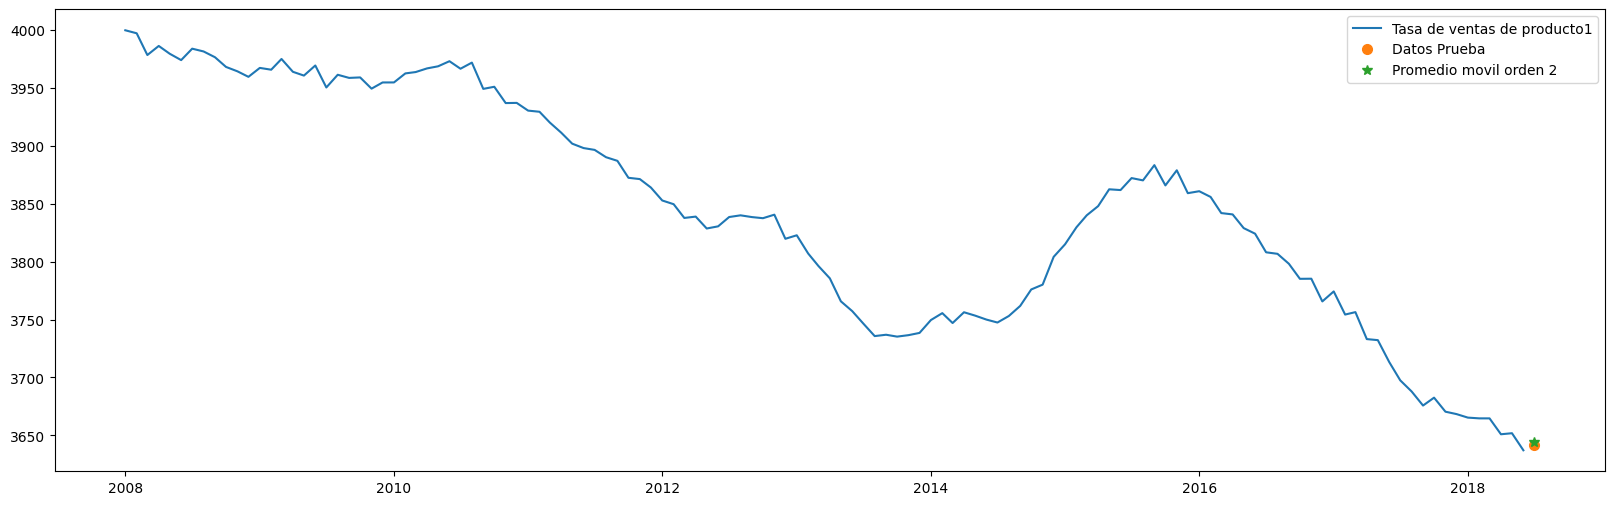

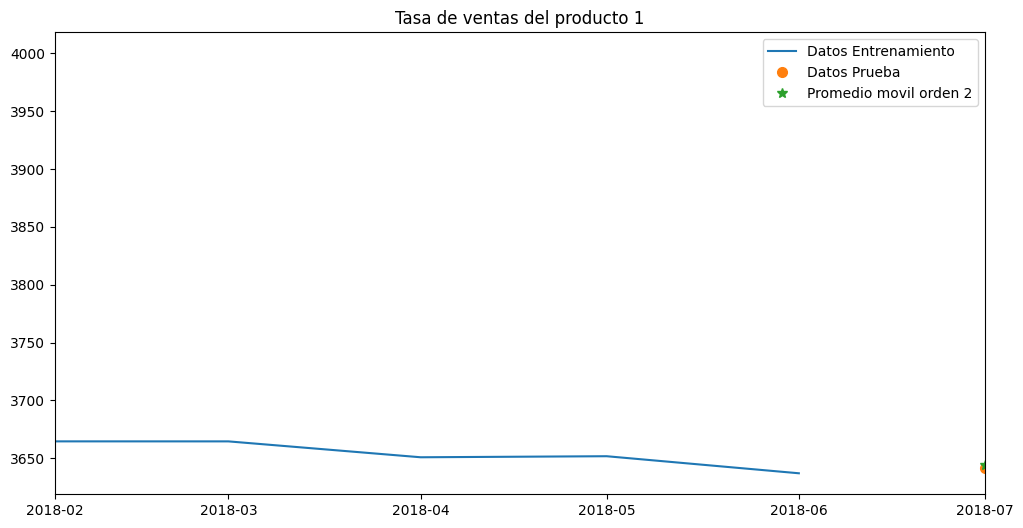

In [35]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_producto1,label="Tasa de ventas de producto1")
plt.plot(test_producto1, label="Datos Prueba", marker='o', markersize=7, linestyle='None')
plt.plot(ma_2_f, label="Promedio movil orden 2", marker='*', markersize=7, linestyle='None')
plt.legend()
plt.show()

# Acercamos un poco la gráfica para identificar el punto de prueba
fig = plt.figure(figsize=(12, 6))
plt.title("Tasa de ventas del producto 1")
plt.plot(train_producto1, label="Datos Entrenamiento")
plt.plot(test_producto1, label="Datos Prueba", marker='o', markersize=7, linestyle='None')
plt.plot(ma_2_f, label="Promedio movil orden 2", marker='*', markersize=7, linestyle='None')
plt.legend()

# Ajustar los límites del eje x para enfocarse en los últimos puntos
plt.xlim(train_producto1.index[-5], ma_2_f.index[-1])

plt.show()

#### 5.1.2 Promedio movil para producto2

In [36]:
## Considerando el dato actual
ma_2= train_producto2.rolling(2,min_periods=2).mean()
ma_3= train_producto2.rolling(3,min_periods=2).mean()
ma_4= train_producto2.rolling(4,min_periods=2).mean()
ma_5= train_producto2.rolling(5,min_periods=2).mean()

In [37]:
## Sin considerar el dato actual
ma_2= train_producto2.shift().rolling(2,min_periods=2).mean()
ma_3= train_producto2.shift().rolling(3,min_periods=2).mean()
ma_4= train_producto2.shift().rolling(4,min_periods=2).mean()
ma_5= train_producto2.shift().rolling(5,min_periods=2).mean()

In [38]:
def fore_ma(datos,w,h): #w es la ventana del promedio para hacer el pronostico (10,15,20,25,30) w=2 (10 con 15, 15 con 20, 20 con 25) w=3 (10 con 15 con 20, )..., h el num de pronosticos hacia adelante
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [39]:
ma_2_f= fore_ma(train_producto2,2,1)
ma_3_f= fore_ma(train_producto2,3,1)
ma_4_f= fore_ma(train_producto2,4,1)
ma_5_f= fore_ma(train_producto2,5,1)

In [40]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_producto2,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_producto2,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_producto2,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_producto2,ma_5_f ))

In [41]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5)

13.216278826005237 21.797060877263448 28.03906021811008 32.74244616180431


In [42]:
# Crear una lista con los valores de RMSE
rmse_values = [rmse_ma_2, rmse_ma_3, rmse_ma_4, rmse_ma_5]

# Encontrar el valor mínimo, que sería la mejor opción
min_rmse = min(rmse_values)

# Imprimir el valor mínimo y su correspondiente modelo
if min_rmse == rmse_ma_2:
    print(f"El mejor modelo es MA(2) con un RMSE de {min_rmse} para producto2")
elif min_rmse == rmse_ma_3:
    print(f"El mejor modelo es MA(3) con un RMSE de {min_rmse} para producto2")
elif min_rmse == rmse_ma_4:
    print(f"El mejor modelo es MA(4) con un RMSE de {min_rmse} para producto2")
else:
    print(f"El mejor modelo es MA(5) con un RMSE de {min_rmse} para producto2")

El mejor modelo es MA(2) con un RMSE de 13.216278826005237 para producto2


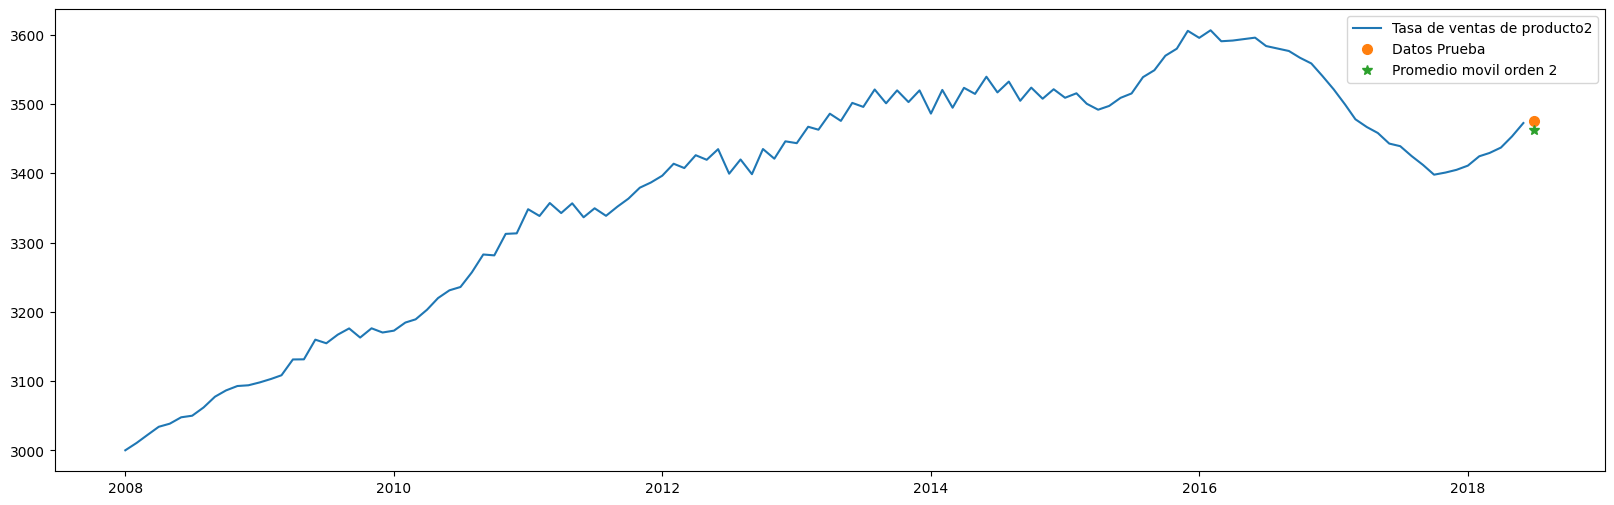

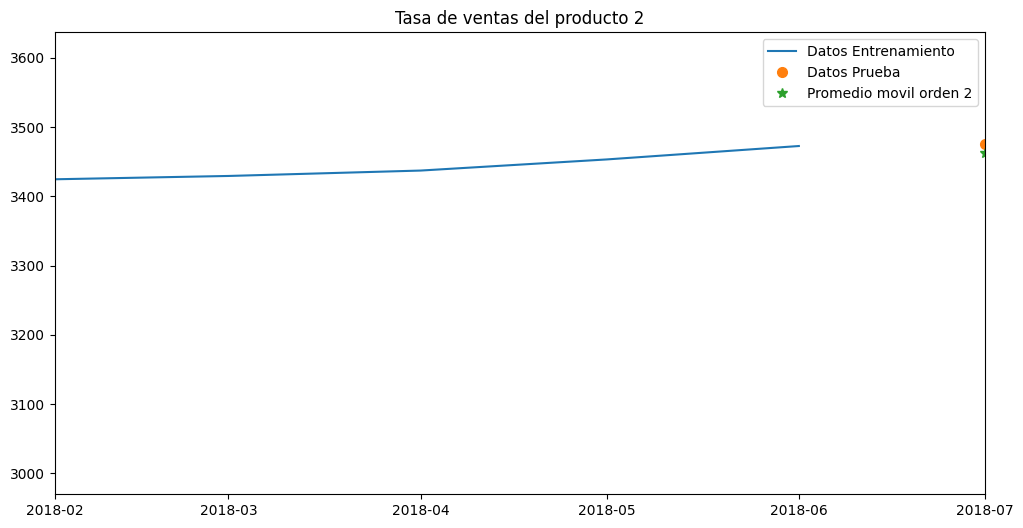

In [43]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_producto2, label="Tasa de ventas de producto2")
plt.plot(test_producto2, label="Datos Prueba", marker='o', markersize=7, linestyle='None')
plt.plot(ma_2_f, label="Promedio movil orden 2", marker='*', markersize=7, linestyle='None')
plt.legend()
plt.show()

# Acercamos un poco la gráfica para identificar el punto de prueba
fig = plt.figure(figsize=(12, 6))
plt.title("Tasa de ventas del producto 2")
plt.plot(train_producto2, label="Datos Entrenamiento")
plt.plot(test_producto2, label="Datos Prueba", marker='o', markersize=7, linestyle='None')
plt.plot(ma_2_f, label="Promedio movil orden 2", marker='*', markersize=7, linestyle='None')
plt.legend()

# Ajustar los límites del eje x para enfocarse en los últimos puntos
plt.xlim(train_producto2.index[-5], ma_2_f.index[-1])

plt.show()

#### 5.2 Promedio movil con los protocolos de evaluación

Protocolo de Ventana Recursiva con Promedio Móvil

In [57]:
"""
def recursive_ma_forecast(train_data, test_data, window_size):
    predictions = []
    history = train_data.copy()
    
    for t in range(len(test_data)):
        # Calcular el pronóstico usando el promedio móvil
        ma_forecast = history[-window_size:].mean()
        predictions.append(ma_forecast)
        
        # Actualizar la ventana con el valor real del test
        history = np.append(history, test_data[t])
        
    return predictions
"""

def recursive_ma_forecast(train_data, test_data, window_size):
    print(f"Train data: {train_data}")
    print(f"Test data: {test_data}")
    print(f"Window size: {window_size}")
    
    # Suponiendo que la función sigue una lógica como esta:
    predictions = []
    for i in range(len(test_data)):
        if i < window_size:
            pred = train_data[-window_size:].mean()  # Media de los últimos valores de train
        else:
            pred = predictions[-window_size:].mean()  # Media de las últimas predicciones
            
        predictions.append(pred)
        
        # Debugging step:
        print(f"Prediction at step {i}: {pred}")
    
    return predictions


Protocolo de Rolling Window con Promedio Móvil

In [56]:
"""
def rolling_ma_forecast(train_data, test_data, window_size):
    predictions = []
    history = train_data.copy()
    
    for t in range(len(test_data)):
        # Calcular el pronóstico usando el promedio móvil en la ventana más reciente
        ma_forecast = history[-window_size:].mean()
        predictions.append(ma_forecast)
        
        # Deslizar la ventana agregando el valor real del test
        history = np.append(history[1:], test_data[t])  # Movemos la ventana
        
    return predictions
"""
def rolling_ma_forecast(train_data, test_data, window_size):
    print(f"Train data: {train_data}")
    print(f"Test data: {test_data}")
    print(f"Window size: {window_size}")
    
    # Asumiendo una lógica básica de rolling window:
    predictions = []
    for i in range(len(test_data)):
        if i < window_size:
            pred = train_data[-window_size:].mean()  # Media de los últimos valores de train
        else:
            pred = test_data[i-window_size:i].mean()  # Media de la ventana rodante
        
        predictions.append(pred)
        
        # Debugging step:
        print(f"Prediction at step {i}: {pred}")
    
    return predictions



Ahora procedemos a realizar los modelos con estos 2 protocolos de evaluación

In [63]:
# Inicializar un DataFrame vacío para almacenar los resultados
results_df = pd.DataFrame(columns=["Modelo", "Enfoque", "Ventana", "RMSE"])

# Definir el rango de tamaños de ventana que quieres evaluar (hasta orden 5 o 6)
window_sizes = range(2, 7)  # Ventanas de tamaño 2 a 6

# Evaluar el modelo para cada tamaño de ventana
for window_size in window_sizes:
    # --- Ventana Recursiva ---
    # Pronóstico para Producto 1
    pred_recursive_p1 = recursive_ma_forecast(train_producto1, test_producto1, window_size)
    rmse_recursive_p1 = np.sqrt(mean_squared_error(test_producto1, pred_recursive_p1))
    
    # Crear un nuevo DataFrame para almacenar los resultados de esta iteración
    new_row = pd.DataFrame([{
        "Modelo": "Promedio Móvil Producto 1",
        "Enfoque": "Ventana Recursiva",
        "Ventana": window_size,
        "RMSE": rmse_recursive_p1
    }])
    
    # Usar pd.concat para agregar la nueva fila al DataFrame de resultados
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    # Pronóstico para Producto 2
    pred_recursive_p2 = recursive_ma_forecast(train_producto2, test_producto2, window_size)
    rmse_recursive_p2 = np.sqrt(mean_squared_error(test_producto2, pred_recursive_p2))
    
    # Crear un nuevo DataFrame para almacenar los resultados de esta iteración
    new_row = pd.DataFrame([{
        "Modelo": "Promedio Móvil Producto 2",
        "Enfoque": "Ventana Recursiva",
        "Ventana": window_size,
        "RMSE": rmse_recursive_p2
    }])
    
    # Usar pd.concat para agregar la nueva fila al DataFrame de resultados
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    # --- Rolling Window ---
    # Pronóstico para Producto 1
    pred_rolling_p1 = rolling_ma_forecast(train_producto1, test_producto1, window_size)
    rmse_rolling_p1 = np.sqrt(mean_squared_error(test_producto1, pred_rolling_p1))
    
    # Crear un nuevo DataFrame para almacenar los resultados de esta iteración
    new_row = pd.DataFrame([{
        "Modelo": "Promedio Móvil Producto 1",
        "Enfoque": "Rolling Window",
        "Ventana": window_size,
        "RMSE": rmse_rolling_p1
    }])
    
    # Usar pd.concat para agregar la nueva fila al DataFrame de resultados
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    """
    # Guardar resultado en el DataFrame
    results_df = results_df.append({
        "Modelo": "Promedio Móvil Producto 1",
        "Enfoque": "Rolling Window",
        "Ventana": window_size,
        "RMSE": rmse_rolling_p1
    }, ignore_index=True)
    """
    
    # Pronóstico para Producto 2
    pred_rolling_p2 = rolling_ma_forecast(train_producto2, test_producto2, window_size)
    rmse_rolling_p2 = np.sqrt(mean_squared_error(test_producto2, pred_rolling_p2))
    
    # Crear un nuevo DataFrame para almacenar los resultados de esta iteración
    new_row = pd.DataFrame([{
        "Modelo": "Promedio Móvil Producto 2",
        "Enfoque": "Rolling Window",
        "Ventana": window_size,
        "RMSE": rmse_rolling_p2
    }])
    
    # Usar pd.concat para agregar la nueva fila al DataFrame de resultados
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    """
    # Guardar resultado en el DataFrame
    results_df = results_df.append({
        "Modelo": "Promedio Móvil Producto 2",
        "Enfoque": "Rolling Window",
        "Ventana": window_size,
        "RMSE": rmse_rolling_p2
    }, ignore_index=True)
    """

# Mostrar el DataFrame con los resultados
#print(results_df)


Train data:               producto1
Mes                    
2008-01-01  4000.000000
2008-02-01  3997.400893
2008-03-01  3978.605317
2008-04-01  3986.454125
2008-05-01  3979.695678
...                 ...
2018-02-01  3664.625472
2018-03-01  3664.610771
2018-04-01  3650.881839
2018-05-01  3651.788470
2018-06-01  3637.047639

[126 rows x 1 columns]
Test data:               producto1
Mes                    
2018-07-01  3641.990873
Window size: 2
Prediction at step 0: producto1    3644.418055
dtype: float64
Train data:               producto2
Mes                    
2008-01-01  3000.000000
2008-02-01  3010.686220
2008-03-01  3022.018584
2008-04-01  3033.920990
2008-05-01  3038.402098
...                 ...
2018-02-01  3424.502102
2018-03-01  3429.293034
2018-04-01  3437.099467
2018-05-01  3453.155282
2018-06-01  3472.528345

[126 rows x 1 columns]
Test data:               producto2
Mes                    
2018-07-01  3476.058092
Window size: 2
Prediction at step 0: producto2    3462.841813

C:\Users\alfa7\AppData\Local\Temp\ipykernel_22216\3497120133.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


In [64]:
print(results_df)


                       Modelo            Enfoque Ventana       RMSE
0   Promedio Móvil Producto 1  Ventana Recursiva       2   2.427182
1   Promedio Móvil Producto 2  Ventana Recursiva       2  13.216279
2   Promedio Móvil Producto 1     Rolling Window       2   2.427182
3   Promedio Móvil Producto 2     Rolling Window       2  13.216279
4   Promedio Móvil Producto 1  Ventana Recursiva       3   4.581777
5   Promedio Móvil Producto 2  Ventana Recursiva       3  21.797061
6   Promedio Móvil Producto 1     Rolling Window       3   4.581777
7   Promedio Móvil Producto 2     Rolling Window       3  21.797061
8   Promedio Móvil Producto 1  Ventana Recursiva       4   9.091307
9   Promedio Móvil Producto 2  Ventana Recursiva       4  28.039060
10  Promedio Móvil Producto 1     Rolling Window       4   9.091307
11  Promedio Móvil Producto 2     Rolling Window       4  28.039060
12  Promedio Móvil Producto 1  Ventana Recursiva       5  11.799966
13  Promedio Móvil Producto 2  Ventana Recursiva

## **Por definir**

## **n---3. Optimización Bayesiana serie producto1**

In [ ]:
def train_and_evaluate_RMSE(error,trend,seasonal,alpha,beta,gamma):
    """Function we want to maximize (Black box)

    It first trains a model with the training set using the received hyper
    parameterts, and then evaluatesand returns the Min RMSE over the test set.
    """

    alpha = round(alpha,2)
    beta  = round(beta,2)
    gamma = round(gamma,2)

    print(error,trend,seasonal)
    print(alpha,beta,gamma)
    error1 = ["add","mul"]
    trend1 = ["add","mul",None]
    seasonal1 = ["add","mul",None]

    model = ETSModel(endog=train_producto1["producto1"],error=error1[round(error)],trend=trend1[round(trend)],seasonal=seasonal1[round(seasonal)])

    params = {'smoothing_level': alpha,'smoothing_trend': beta,'smoothing_seasonal':gamma}

    if trend1[round(trend)] == None:
      params.pop('smoothing_trend')
    if seasonal1[round(seasonal)] == None:
      params.pop('smoothing_seasonal')

    model_result = model.fit_constrained(params)

    point_forecast=model_result.forecast(1)
    rmse = np.sqrt(mean_squared_error(test_producto1["producto1"],point_forecast ))

    print(" target es: {},Eror test: {},Trend test: {},Seasonal test: {},Alpha model: {},Beta model: {}, Gamma model: {}".
          format(rmse,error1[round(error)],trend1[round(trend)],seasonal1[round(seasonal)],alpha,beta,gamma))

    return -rmse

In [ ]:
pbounds = {'error':  (0,1),'trend':(0,2) , 'seasonal': (0,2), 'alpha':(0.01,0.99) , "beta" :(0.01,0.99),"gamma" :(0.01,0.99) }

In [ ]:
optimizer = BayesianOptimization(
    f=train_and_evaluate_RMSE,
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
optimizer.maximize(init_points=3, n_iter=1000)

In [ ]:
#con 1000 iteraciones
optimizer.max

In [ ]:
#con 100 iteracciones
optimizer.max

## Selección del mejor Modelo

In [67]:
# Encontrar el mejor modelo para Producto 1
best_model_p1 = results_df[results_df["Modelo"] == "Promedio Móvil Producto 1"].sort_values("RMSE").head(1)

# Encontrar el mejor modelo para Producto 2
best_model_p2 = results_df[results_df["Modelo"] == "Promedio Móvil Producto 2"].sort_values("RMSE").head(1)

print("\nMejor modelo para Producto 1:\n", best_model_p1)
print("\n\nMejor modelo para Producto 2:\n", best_model_p2)



Mejor modelo para Producto 1:
                       Modelo            Enfoque Ventana      RMSE
0  Promedio Móvil Producto 1  Ventana Recursiva       2  2.427182


Mejor modelo para Producto 2:
                       Modelo            Enfoque Ventana       RMSE
1  Promedio Móvil Producto 2  Ventana Recursiva       2  13.216279
